In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

/kaggle/input/medical-insurance-price-prediction/Medical_insurance.csv


/tmp/ipykernel_32/2507598960.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [134]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

medical = pd.read_csv('../input/medical-insurance-price-prediction/Medical_insurance.csv')
# medical.head()
df = pd.DataFrame(data=medical)
df['Insurance_Category'] = pd.cut(df['charges'], bins=[0, 10000, 20000, 30000, 40000, 50000, 100000],
                     labels=[0,1, 2, 3, 4,5])
df.pop('charges')
# medical.shape

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
2767     8569.86180
2768     2020.17700
2769    16450.89470
2770    21595.38229
2771     9850.43200
Name: charges, Length: 2772, dtype: float64

In [135]:
X = df.copy()
y = X.pop('Insurance_Category')

features_num = ['age', 'bmi', 'children']
features_cat = ['sex', 'smoker', 'region']

transformer_num = make_pipeline(
    StandardScaler(),
)
transformer_cat = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]
pd.DataFrame(X_train[:6,:]).head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.473137,-0.783811,3.218784,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.544426,-0.208210,-0.090737,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.168468,-1.175607,0.736643,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,-0.524915,1.051018,0.736643,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.952651,-0.302531,-0.918117,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [136]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),
    layers.Dense(25, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(15, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(6, activation='linear'),
])

In [137]:
model.compile(
    loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer= keras.optimizers.Adam(learning_rate=0.001),
)

In [138]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=100,
    callbacks =[early_stopping]
)

Epoch 1/100
65/65 [==============================] - 1s 6ms/step - loss: 1.7851 - val_loss: 1.5590
Epoch 2/100
65/65 [==============================] - 0s 3ms/step - loss: 1.2502 - val_loss: 1.2032
Epoch 3/100
65/65 [==============================] - 0s 3ms/step - loss: 0.9888 - val_loss: 0.9407
Epoch 4/100
65/65 [==============================] - 0s 4ms/step - loss: 0.8472 - val_loss: 0.7850
Epoch 5/100
65/65 [==============================] - 0s 3ms/step - loss: 0.7621 - val_loss: 0.6979
Epoch 6/100
65/65 [==============================] - 0s 3ms/step - loss: 0.6983 - val_loss: 0.6414
Epoch 7/100
65/65 [==============================] - 0s 3ms/step - loss: 0.6700 - val_loss: 0.6009
Epoch 8/100
65/65 [==============================] - 0s 3ms/step - loss: 0.6447 - val_loss: 0.5739
Epoch 9/100
65/65 [==============================] - 0s 3ms/step - loss: 0.6244 - val_loss: 0.5536
Epoch 10/100
65/65 [==============================] - 0s 3ms/step - loss: 0.5944 - val_loss: 0.5328
Epoch 11/

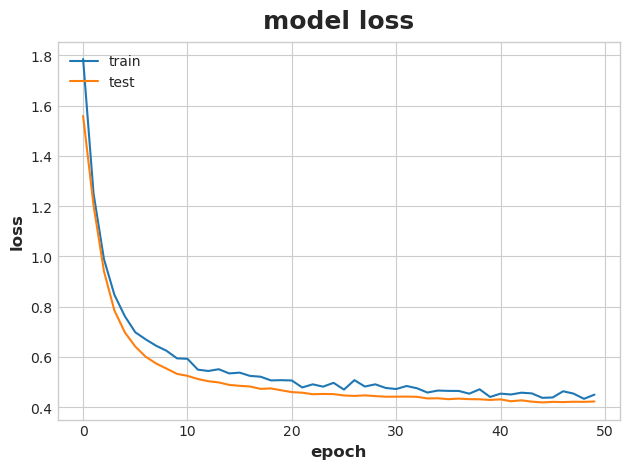

In [139]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [140]:
#add a sample user profile here, and get the prediction for which insurance category he/she would belong
newData= {
    'age':60,
    'sex' :'female',
    'bmi':36.005,
    'children':0,
    'smoker':'no',
    'region':'northeast'
}
myData = pd.DataFrame(newData, index = [0])
transformedSample = preprocessor.transform(myData)

In [141]:
prediction = model.predict(transformedSample.reshape(1,11))  # prediction

print(f" predicting: \n{prediction}")
print(f" Largest Prediction index: {np.argmax(prediction)}")

1/1 [==============================] - 0s 81ms/step
 predicting: 
[[-0.27612084  4.8852425   2.1012156  -0.4880324  -2.5330188  -3.2425065 ]]
 Largest Prediction index: 1
